In [3]:
import numpy as np

def mirror_shift(row, shift):
    """
    Shift a row of data by a given amount, mirroring the data if the shift goes out of bounds.
    """
    if shift == 0:
        return row
    elif shift > 0:
        return np.concatenate((row[:shift][::-1], row[:-shift]))
    else:
        return np.concatenate((row[-shift:], row[shift:][::-1]))

def segment_sample(data, orientation, segment_len=64, random_offset=0):
    padded_side, _, num_cols = data.shape
    side = padded_side #- 2 * segment_len
    if orientation == 'vertical':
        data = np.transpose(data, (1, 0, 2))
    elif not (orientation == 'horizontal'):
        raise ValueError(f"Unknown orientation {orientation}")
    segments = np.zeros(( (side**2) // segment_len, num_cols, segment_len), dtype=np.float32)

    offset = segment_len + random_offset
    for i in range(num_cols):
        segments[:, i, :] = data[segment_len:-segment_len, offset:offset + side, i].reshape((side ** 2) // segment_len, segment_len)
    return segments

from fco2dataset.ucollocate import get_day_data, collocate
def get_day_dataset(date):
    # get global satellite data for a given date
    dss = get_day_data(date, save_path='../data/inference/gridded')
    return dss

def collocate_coords(df, dss, date):
    save_path = '../data/inference/collocated'
    df_collocated = collocate(df, date, save_path=save_path, dss=dss, verbose=False)
    return df_collocated

def normalize(df, stats, mode):
    for i in range(1, len(stats['means'])): # first column is the target
        col = df.columns[i - 1]
        # print(f"Normalizing {col} with {mode}")
        if mode == 'min_max':
            # print(f"Min: {stats['mins'][i]}, Max: {stats['maxs'][i]}")
            df[col] = 2 * (df[col] - stats['mins'][i]) / (stats['maxs'][i] - stats['mins'][i]) - 1
        elif mode == 'mean_std':
            df[col] = (df[col] - stats['means'][i]) / stats['stds'][i]
        else:
            raise ValueError(f"Unknown mode {mode}")
    return df

In [2]:
import healpy as hp

def get_nested_patch(patch_ix, patch_size, nside=1024, plot=False):
    patch_pix = np.arange(patch_ix * patch_size, (patch_ix + 1) * patch_size)
    xyf = hp.pix2xyf(nside, patch_pix, nest=True)
    xyf = (xyf[0]  - xyf[0].min(), xyf[1]  - xyf[1].min(), xyf[2])
    lon, lat = hp.pix2ang(nside, patch_pix, nest=True, lonlat=True)

    if plot:
        side = int(np.sqrt(patch_size))
        plot_patch(patch_ix, patch_size, xyf[0] * side + xyf[1], nside=nside)
    return xyf, lon, lat, patch_pix

def plot_patch(patch_ix, patch_size, data, nside=1024):
    npix = hp.nside2npix(nside)
    m = np.full(npix, np.nan)
    patch_pix = np.arange(patch_ix * patch_size, (patch_ix + 1) * patch_size)
    m[patch_pix] = data
    hp.mollview(m, title=f"Patch {patch_ix}", nest=True)


Number of patches: 12


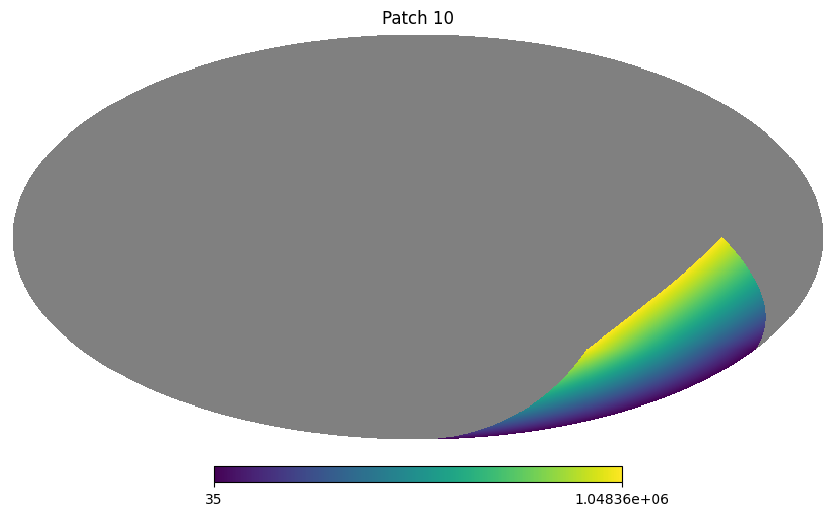

In [3]:
NSIDE = 1024
npix = hp.nside2npix(NSIDE)
face_pixs = npix//12
num_subfaces = 1 # number of subfaces should a power of 4
patch_size = face_pixs // num_subfaces
n_patches = npix // patch_size
print(f"Number of patches: {n_patches}")
xyf, lon, lat, patch_pix = get_nested_patch(10, patch_size, nside=NSIDE, plot=True)


In [4]:
import pandas as pd
from fco2models.utraining import prep_df


def get_patch_ds(params, patch_ix, patch_size, date, nside=NSIDE, dss=None):
    predictors = params['predictors']
    stats = {
    'means':params['train_means'],
    'stds':params['train_stds'],
    'mins':params['train_mins'],
    'maxs':params['train_maxs']
    }

    # get the patch coordinates
    xyf, lon, lat, patch_pix = get_nested_patch(patch_ix, patch_size, nside=nside)
    if dss is None:
        dss = get_day_dataset(date)
    coords = pd.DataFrame({
        'lon': lon.flatten(),
        'lat': lat.flatten(),
        'x': xyf[0].flatten(),
        'y': xyf[1].flatten(),
        'f': xyf[2].flatten(),
        'patch_pix': patch_pix,
    })
    coords['time_1d'] = date
    # collocate the data
    context_df = collocate_coords(coords, dss, date)
    context_df['lon'] = (context_df['lon'] + 180) % 360 - 180
    context_df = prep_df(context_df, with_target=False, with_log=False)[0][predictors + ['x', 'y']]
    context_df = normalize(context_df, stats, params['mode'])
    #context_df = context_df.fillna(context_df.mean())  # fill NaNs with mean of each column

    height = width = np.sqrt(patch_size).astype(int)
    context_ds = np.zeros((height, width, len(predictors) + 3), dtype=np.float32)
    x = context_df['x'].values.astype(int)
    y = context_df['y'].values.astype(int)
    for i, col in enumerate(predictors):
        context_ds[x, y, i] = context_df[col].values
    # add lat lon
    context_ds[x, y, -2] = lat
    context_ds[x, y, -1] = lon
    context_ds[x, y, -3] = patch_pix.flatten()

    return context_ds


import torch
from tqdm import tqdm
def infer_patch(model, noise_scheduler, params, patch_ix, patch_size, date, nside=NSIDE, dss=None, jump=20):
    
    # get dataset collocated for the patch
    context_ds = get_patch_ds(params, patch_ix, patch_size, date, nside=nside, dss=dss)
    lat = context_ds[:, :, -2] # later used for plotting
    lon = context_ds[:, :, -1] # later used for plotting
    patch_pix = context_ds[:, :, -3] # later used for plotting
    
    context_ds = context_ds[:, :, :-3] # model input
    side = np.sqrt(patch_size).astype(int)
    segment_len = 64

    # pad the context for random shifts (to avoid edge effects)
    padded_side = side + 2 * segment_len
    padded_context_ds = np.zeros((padded_side, padded_side, context_ds.shape[2]), dtype=np.float32)
    padded_context_ds[segment_len: -segment_len, segment_len: -segment_len, :] = context_ds
    padded_context_ds[segment_len:-segment_len, :segment_len, :] = context_ds[:, :segment_len, :][:, ::-1, :] # just mirror the data for now
    padded_context_ds[segment_len:-segment_len, -segment_len:, :] = context_ds[:, -segment_len:, :][:, ::-1, :]
    
    sample_col = np.random.randn(padded_side, padded_side, 1).astype(np.float32)
    sample_context_ds = np.concatenate([sample_col, padded_context_ds, np.ones_like(sample_col)], axis=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    step = 0
    t_loop = tqdm(noise_scheduler.timesteps[::jump], desc="Denoising steps")
    
    for t in t_loop:
        random_offset = np.random.randint(-60, 60)
        if step % 2 == 0:
            segments = segment_sample(sample_context_ds.copy(), 'horizontal', segment_len=64, random_offset=random_offset)
        else:
            segments = segment_sample(sample_context_ds.copy(), 'vertical', segment_len=64, random_offset=random_offset)

        ds = torch.from_numpy(segments).to(device).float()
        #print(f"ds shape: {ds.shape}")
        dataloader = torch.utils.data.DataLoader(ds, batch_size=200, shuffle=False)
        samples = []
        for (ix, batch) in enumerate(dataloader):
            with torch.no_grad():
                batch = batch.to(device)
                #context = batch[:, 1:, :].to(device)
                sample_prev = batch[:, 0:1, :].to(device)
                noise_pred = model(batch, t, return_dict=False)[0]
                x_0 = noise_scheduler.step(noise_pred, t, sample_prev).pred_original_sample
                if t - jump > 0:
                    sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample_prev), t - jump)
                else:
                    sample = x_0
                sample[torch.isnan(sample)] = sample_prev[torch.isnan(sample)]
                samples.append(sample.cpu().numpy())
            t_loop.set_postfix({"batch":{ix}})
        
        samples = np.concatenate(samples, axis=0)
        #padded_samples = np.full((padded_side, padded_side, 1), np.nan, dtype=np.float32)
        offset = random_offset + segment_len
        if step % 2 == 0:
            samples = samples.reshape(side, side)
            sample_context_ds[segment_len:segment_len + side, offset:offset + side, 0] = samples
            #samples = undo_shift(samples, sample_context_ds, random_offset)
        else:
            samples = samples.reshape(side, side).T
            sample_context_ds[offset:offset + side, segment_len:segment_len + side, 0] = samples
            #samples = undo_shift(samples, sample_context_ds, random_offset).T
        
        #samples = samples[:, :, np.newaxis]  # add channel dimension
        #sample_context_ds = np.concatenate([padded_samples, padded_context_ds, np.ones_like(sample_col)], axis=2)
        #step += 1
    
    # remove padding from result
    sample_context_ds = sample_context_ds[segment_len:-segment_len, segment_len:-segment_len, :]
    return np.concatenate([sample_context_ds, lat[:,:, np.newaxis], lon[:,:, np.newaxis], patch_pix[:, :, np.newaxis]], axis=2)

In [5]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/newds/'
model_path = 'e_200.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("model loaded")
print("predictors:", params['predictors'])
date = pd.Timestamp('2022-10-04')
dss = get_day_dataset(date)

face_pixs = npix//12
num_subfaces = 1 # number of subfaces should a power of 4
patch_size = face_pixs // num_subfaces
print(f"Number of patches: {n_patches}")
print(f"Patch size: {patch_size}")

patch_ixs = range(12)
samples = []
for patch_ix in patch_ixs:
    sample = infer_patch(model, noise_scheduler, params, patch_ix, patch_size, date, nside=NSIDE, dss=dss, jump=20)
    samples.append(sample)

sample = np.concatenate(samples, axis=0)

model loaded
predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'co2_clim8d', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']
All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridde

Denoising steps:   8%|▊         | 4/50 [1:54:25<21:55:53, 1716.39s/it, batch={28}]


KeyboardInterrupt: 

In [ ]:
np.isnan(sample[:, :, 0]).sum() / sample[:, :, 0].size * 100

np.float64(0.0)

In [55]:
sample[:, :,0]

array([[-0.11387471, -0.11149789, -0.10267615, ...,  0.21174908,
         0.18233979,  0.09892631],
       [-0.08132759, -0.05675919, -0.06168938, ...,  0.15459195,
         0.24946569,  0.15684636],
       [-0.01938449,  0.00112958,  0.00674498, ...,  0.1802045 ,
         0.14490144,  0.10898658],
       ...,
       [ 0.02510235, -0.05942494, -0.08991782, ...,  0.19645134,
         0.19804499,  0.19903292],
       [-0.160694  , -0.1654818 , -0.08205395, ...,  0.20259269,
         0.20540828,  0.20735925],
       [-0.07503816, -0.09876979,  0.07634459, ...,  0.18426569,
         0.18544622,  0.18640676]], shape=(3072, 1024), dtype=float32)

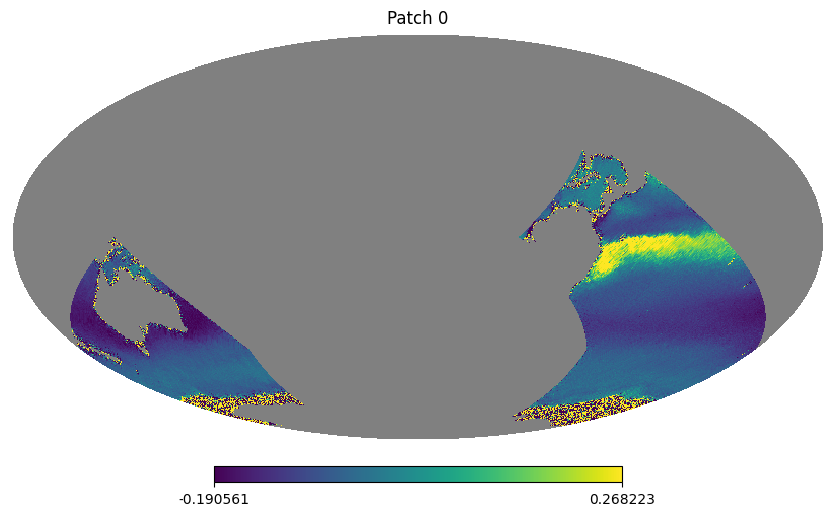

In [56]:
m = np.full(npix, np.nan)
#patch_pix = np.arange(0 * patch_size, (0 + 1) * patch_size)
patch_pix = sample[:, :, -1].flatten().astype(int)
# clip sample between 5th and 95th percentile
feature_ix = 0
sample[np.isnan(sample[:, :, 1]), 0] = np.nan
robust_sample = np.clip(sample[:, :, feature_ix], np.nanpercentile(sample[:, :, feature_ix], 5), np.nanpercentile(sample[:, :, feature_ix], 95))
m[patch_pix] = robust_sample.flatten()
hp.mollview(m, title=f"Patch {0}", nest=True)

In [57]:
lon, lat = hp.pix2ang(NSIDE, patch_pix, nest=True, lonlat=True)
sample_ds = pd.DataFrame({
    'lon': lon.flatten(),
    'lat': lat.flatten(),
    'fco2': sample[:, :, 0].flatten(),
    'sst_cci': sample[:, :, 1].flatten(),
    'sss_cci': sample[:, :, 2].flatten(),
})
print(sample_ds.lon.min(), sample_ds.lon.max(), sample_ds.lat.min(), sample_ds.lat.max())
sample_ds['lon'] = (sample_ds['lon'] + 180) % 360 - 180  # normalize lon to [-180, 180]
sample_ds['lon'] = np.round(sample_ds['lon']*4, 0) / 4
sample_ds['lat'] = np.round(sample_ds['lat']*4, 0) / 4
sample_ds.set_index(['lon', 'lat'], inplace=True)

90.04394531249999 314.9560546875 -89.95431463934247 41.76028861947634


In [58]:
sample_ds = sample_ds.groupby(['lat', 'lon']).mean().to_xarray()

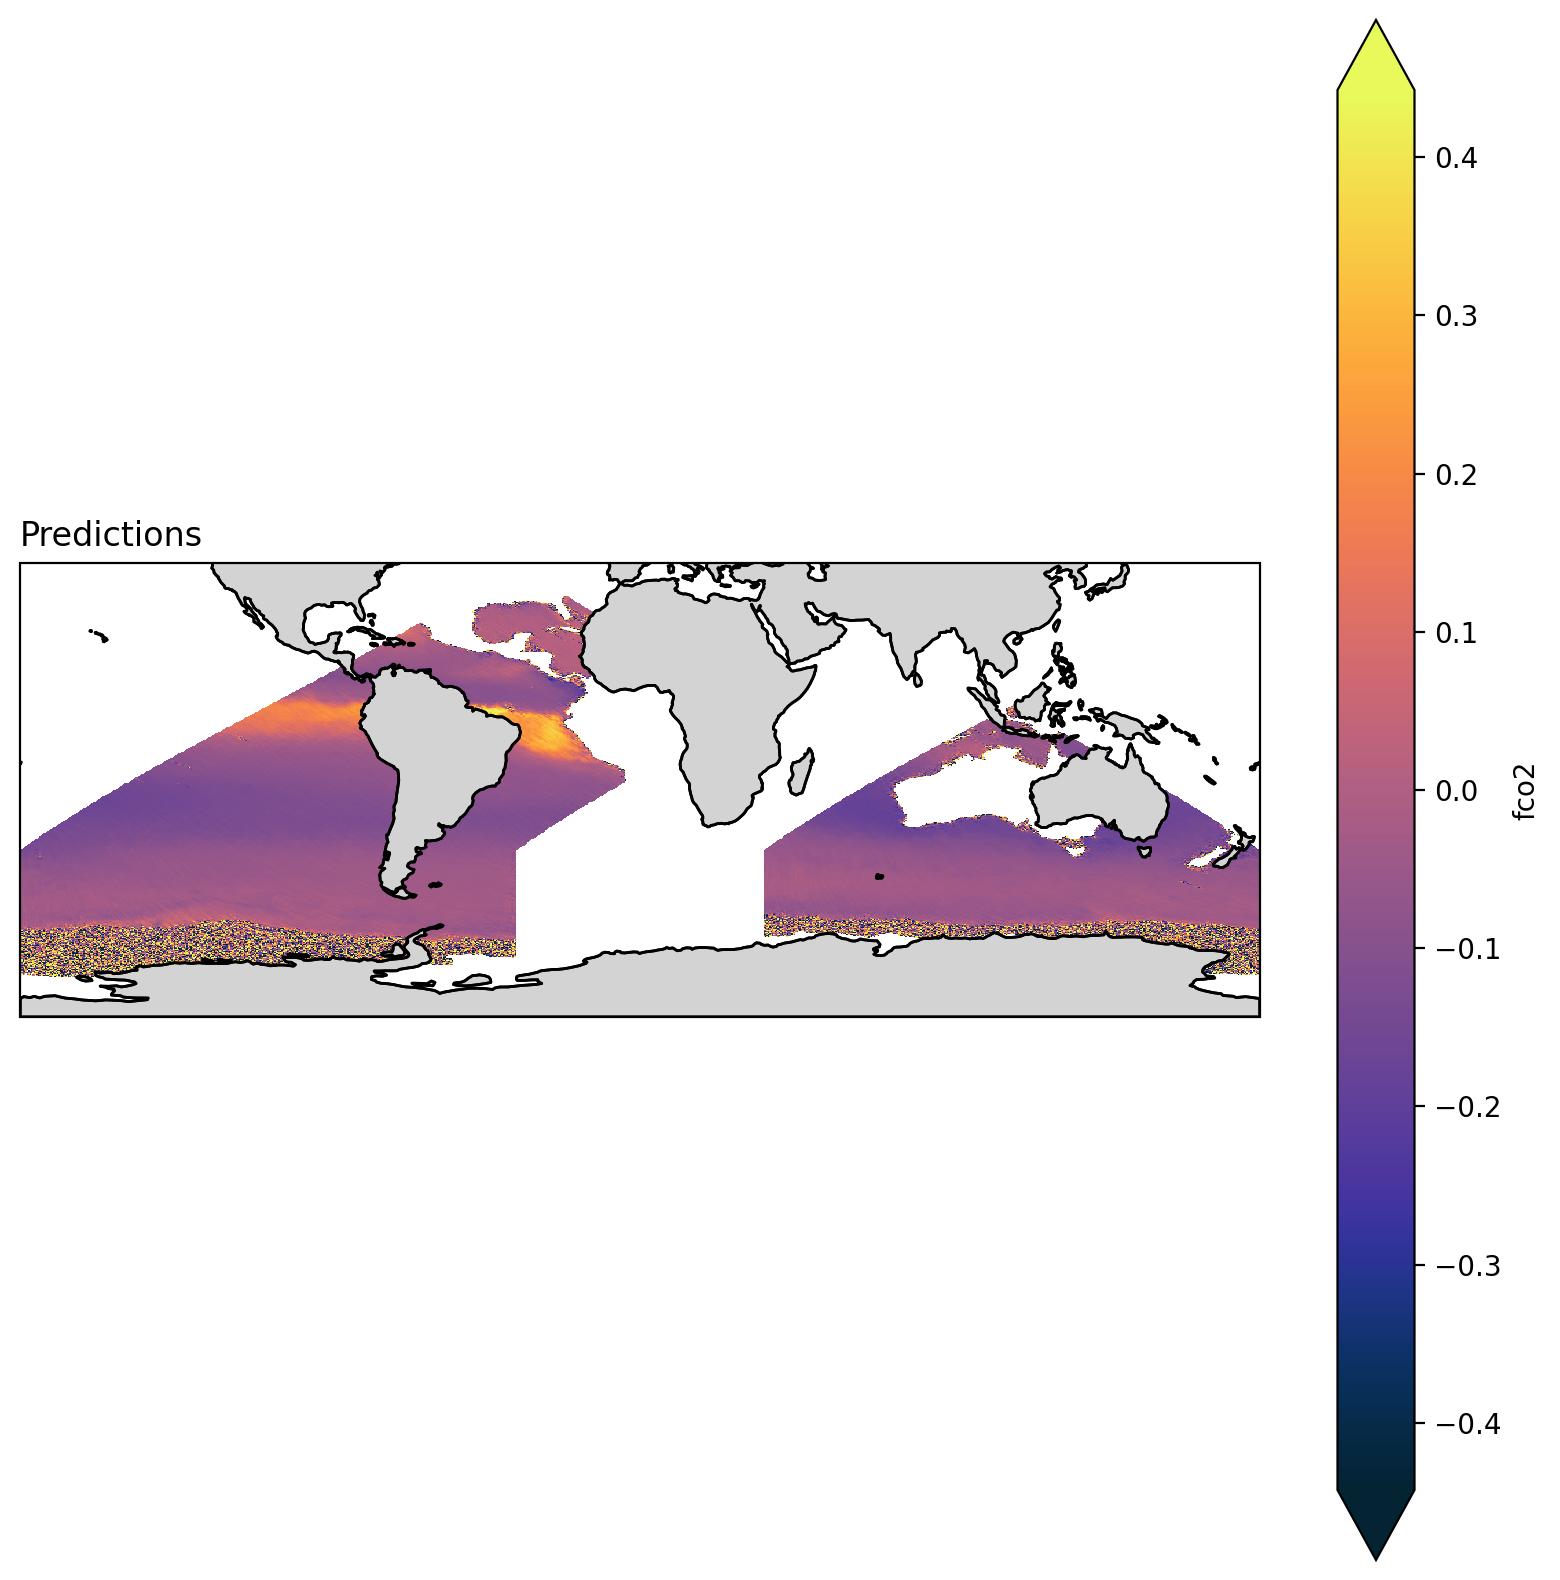

In [59]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.set_global()
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, zorder=2, edgecolor='black')

ax.set_title('Predictions', fontsize=12, loc='left')

(sample_ds
 #.sel(lat=slice(0, 15), lon=slice(move_lon(30), move_lon(46)))
 .fco2
 #.ffill(dim='lat')
 .plot
 .imshow(cmap='cmo.thermal', 
         ax=ax, add_colorbar=True, 
         transform=ccrs.PlateCarree(), 
         robust=True,
         #interpolation='gaussian',
         ))

In [51]:
malvinas = (-71, -56, -35, -11)  # (lon_min, lat_min, lon_max, lat_max)
eq_pacific = (-144, -18, -63, -18) 
lon_min, lat_min, lon_max, lat_max = malvinas

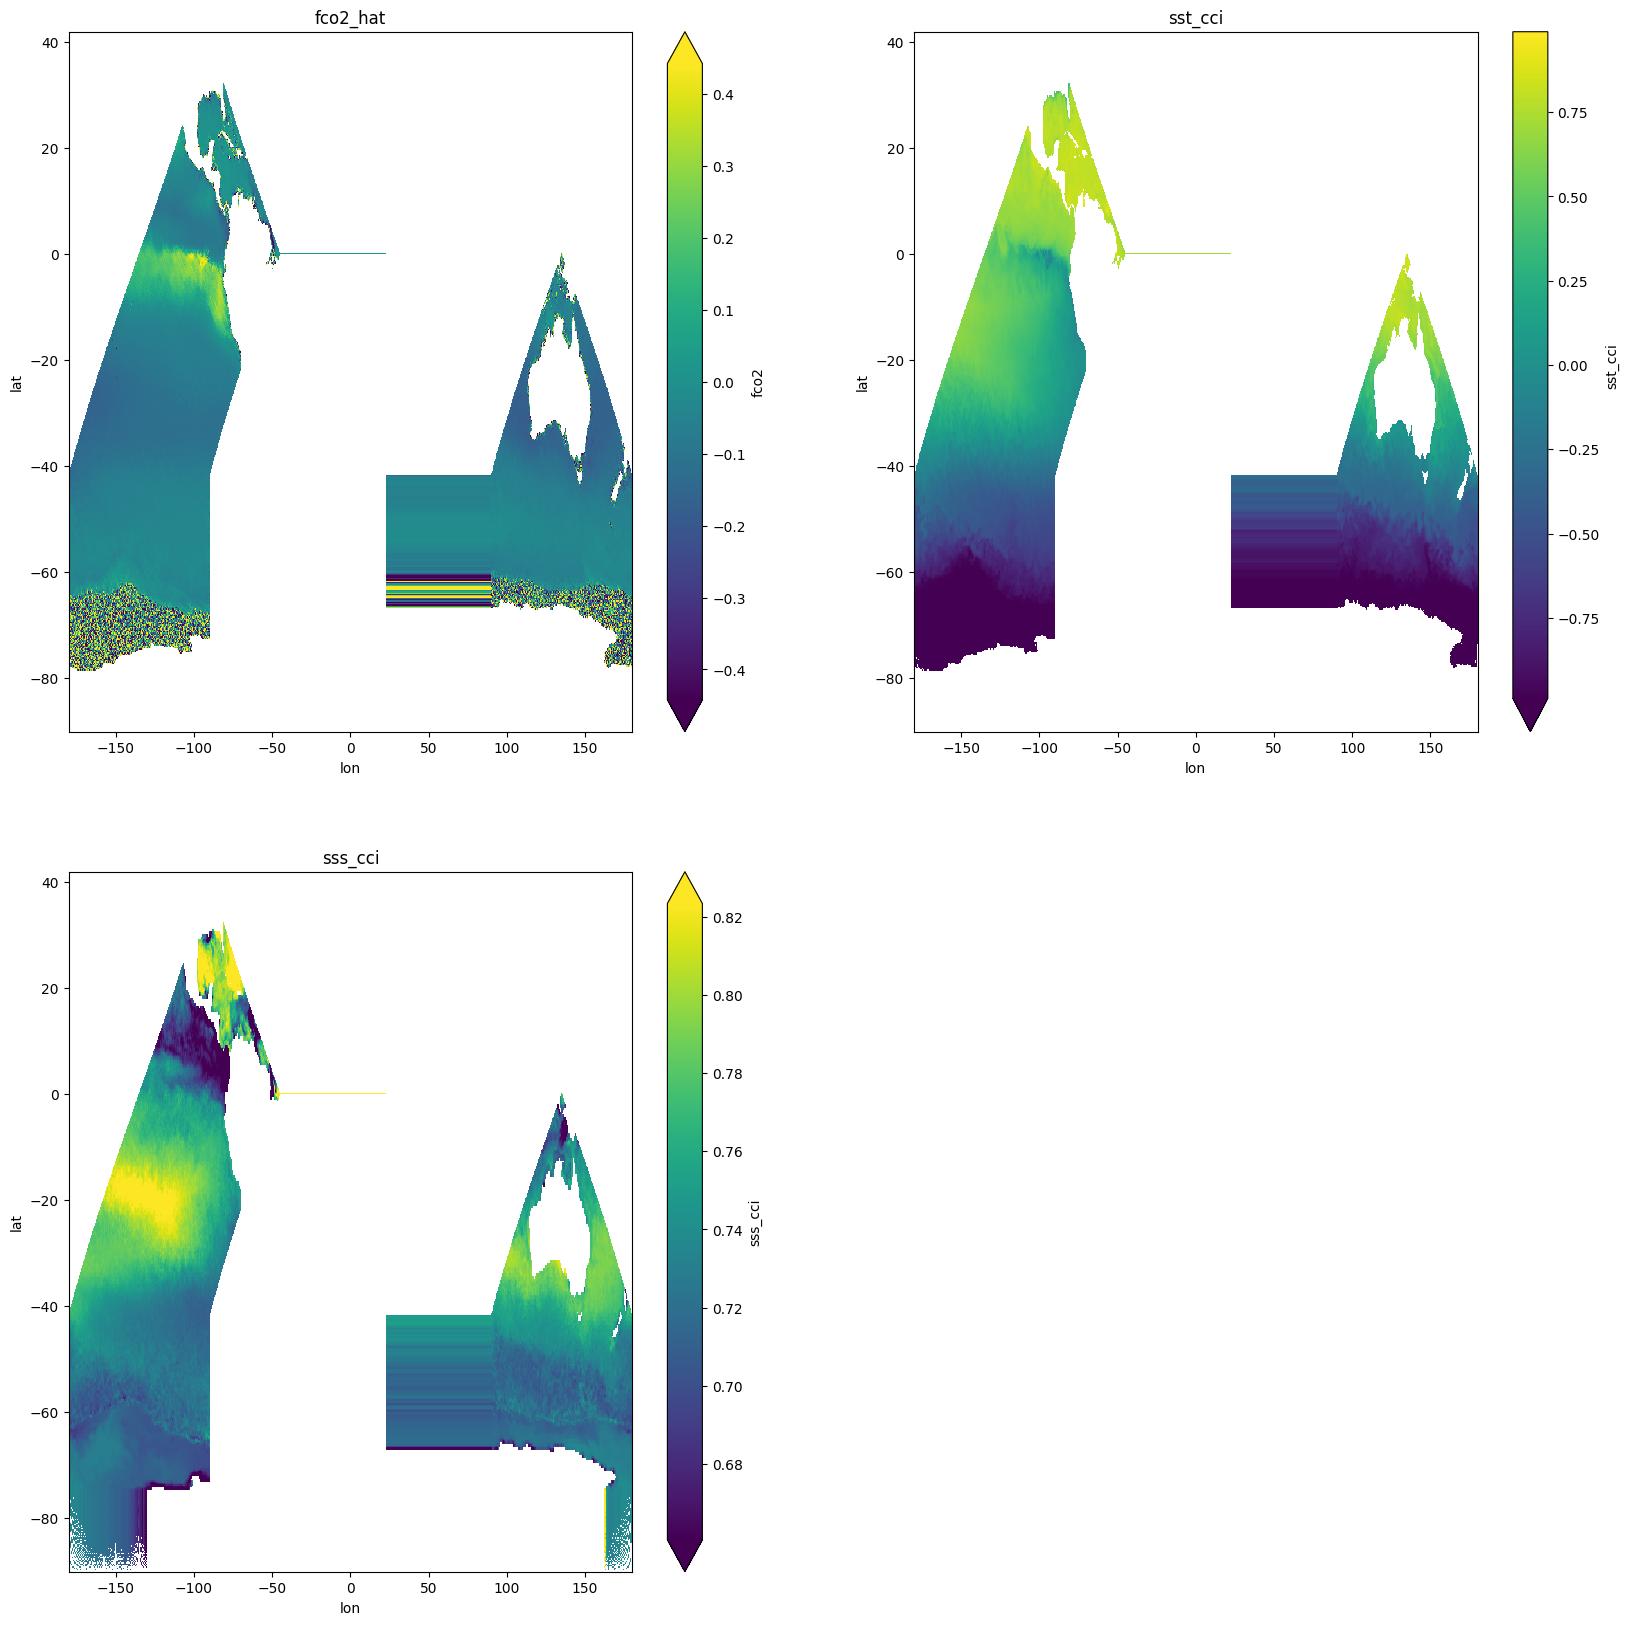

In [60]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(20, 20))
plot_ds = sample_ds#.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
plot_ds.fco2.plot(ax=axs[0, 0], robust=True, cmap="viridis")
axs[0, 0].set_title("fco2_hat")
plot_ds.sst_cci.plot(ax=axs[0, 1], robust=True, cmap="viridis")
axs[0, 1].set_title("sst_cci")
plot_ds.sss_cci.plot(ax=axs[1, 0], robust=True, cmap="viridis")
axs[1, 0].set_title("sss_cci")
axs[1,1].set_visible(False)
plt.show()

inference with random rotations

In [11]:
import healpy as hp
import numpy as np

nside = 256
npix = hp.nside2npix(nside)
nest = True  # Use nested scheme

m = np.arange(npix)
lon,lat = hp.pix2ang(nside, m, nest=nest, lonlat=True)
rot = hp.Rotator(rot=(0, 90, 0), eulertype="ZYX")
lon, lat = rot(lon, lat, lonlat=True)
m2 = hp.ang2pix(nside, lon, lat, nest=nest, lonlat=True)

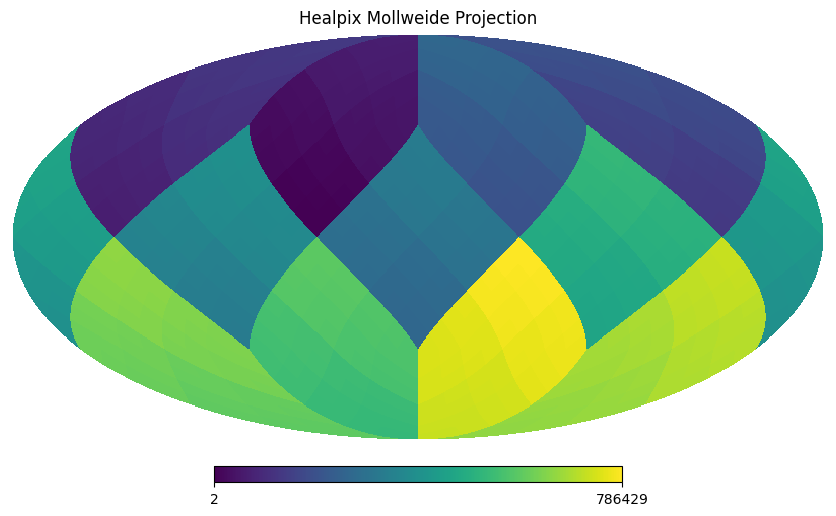

In [12]:
hp.mollview(m, title="Healpix Mollweide Projection", nest=nest, cmap='viridis')

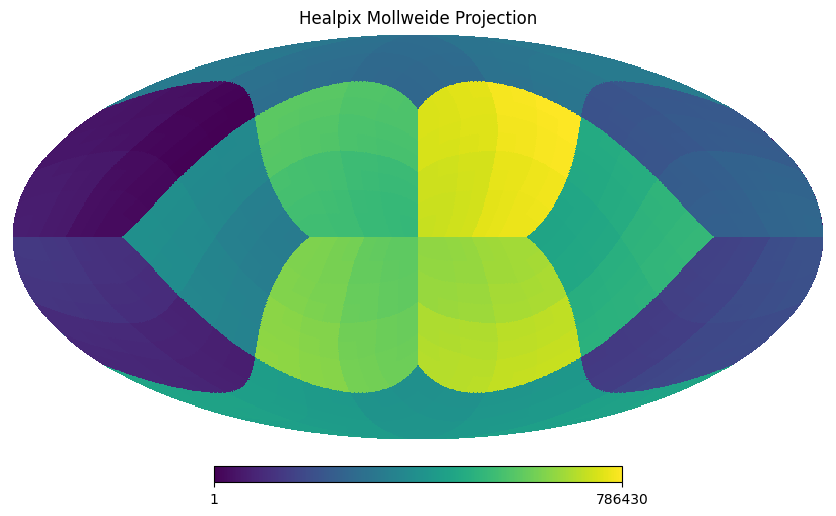

In [13]:
hp.mollview(m2, title="Healpix Mollweide Projection", nest=nest, cmap='viridis')

In [39]:
np.unique(m2).size / npix * 100

100.0

In [51]:
fnpix = npix // 12
fpix = np.arange(fnpix)
xyf = hp.pix2xyf(nside, fpix, nest=nest)
print(xyf[0][:10], xyf[1][:10], xyf[2][:10])

[0 1 0 1 2 3 2 3 0 1] [0 0 1 1 0 0 1 1 2 2] [0 0 0 0 0 0 0 0 0 0]


In [ ]:
import torch
from tqdm import tqdm
import healpy as hp
import numpy as np
from fco2models.utraining import prep_df
import time


def segment_ds(data, orientation, segment_len=64):
    side, _, num_cols = data.shape

    if orientation == 'vertical':
        data = np.transpose(data, (1, 0, 2))
    elif not (orientation == 'horizontal'):
        raise ValueError(f"Unknown orientation {orientation}")
    segments = np.zeros(( (side**2) // segment_len, num_cols, segment_len), dtype=np.float32)
    for i in range(num_cols):
        segments[:, i, :] = data[:, :, i].reshape((side ** 2) // segment_len, segment_len)
    return segments


def fdf_to_numpy(df, cols, nside):
    fnpix = df.shape[0]
    fpix = np.arange(fnpix)
    xyf = hp.pix2xyf(nside, fpix, nest=True)
    x,y = xyf[0], xyf[1]
    fds = np.full((nside, nside, len(cols)), np.nan, dtype=np.float32)
    fds[x, y, :] = df.values
    assert np.isnan(df.values[:, 0]).sum() == 0, "NaN values found in dataframe" # there should be no NaN values in the sample column (every coordinate should have a sample)
    assert np.isnan(fds[:, :, 0]).sum() == 0, "NaN values found in fds" # there should be no NaN values in the sample column (every coordinate should have a sample)
    return fds, x, y

def do_step_loader(model, noise_scheduler, dataloader, t, device, jump):
    samples = []
    for (ix, batch) in enumerate(dataloader):
        with torch.no_grad():
            batch = batch.to(device)
            sample_prev = batch[:, 0:1, :].to(device)
            #sample_prev = noise_scheduler.add_noise(sample_prev, torch.randn_like(sample_prev), t)
            noise_pred = model(batch, t, return_dict=False)[0]
            x_0 = noise_scheduler.step(noise_pred, t, sample_prev).pred_original_sample
            if jump is None:
                sample = noise_scheduler.step(noise_pred, t, sample_prev).prev_sample
            elif t - jump > 0:
                #sample = x_0 
                sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample_prev), t - jump)
            else:
                sample = x_0
                #sample = noise_scheduler.step(noise_pred, t, sample_prev).prev_sample
            sample[torch.isnan(sample)] = sample_prev[torch.isnan(sample)]
            samples.append(sample.cpu().numpy())
    return np.concatenate(samples, axis=0)

def do_random_rot(lon, lat):
        random_zrotation = np.random.random() * 360
        rot = hp.Rotator(rot=(random_zrotation, 0, 0), eulertype="ZYX") # rotate only around the z-axis, so we do not mix equatirial and polar coordinates
        lon_rot, lat_rot = rot(lon, lat, lonlat=True)
        m_rot = hp.ang2pix(nside, lon_rot, lat_rot, nest=True, lonlat=True)
        return m_rot


def infer_patch_with_rotations(model, noise_scheduler, params, date, nside=1024, jump=None, n_samples=1):

    npix = hp.nside2npix(nside)
    print(f"Number of pixels: {npix}")
    m = np.arange(npix)
    lon, lat = hp.pix2ang(nside, m, nest=True, lonlat=True)
    sample = np.random.randn(npix, 1).astype(np.float32)
    dss = get_day_dataset(date)
    context_df = collocate_coords(pd.DataFrame({
        'lon': lon.flatten(),
        'lat': lat.flatten(),
        'time_1d': date,
        }), dss, date)
    print(f"Collocated data shape: {context_df.shape}")
    
    context_df['lon'] = (context_df['lon'] + 180) % 360 - 180
    df = prep_df(context_df, with_target=False, with_log=True)[0]
    df['sst_clim'] += 273.15
    df['sst_anom'] = df['sst_cci'] - df['sst_clim']
    df['sss_anom'] = df['sss_cci'] - df['sss_clim']
    df['chl_anom'] = df['chl_globcolour'] - df['chl_clim']
    df['ssh_anom'] = df['ssh_sla'] - df['ssh_clim']
    df['mld_anom'] = df['mld_dens_soda'] - df['mld_clim']
    context_df = df.loc[:, params['predictors']]
    stats = {
        'means': params['train_means'],
        'stds': params['train_stds'],
        'mins': params['train_mins'],
        'maxs': params['train_maxs']
    }
    context_df = normalize(context_df,stats, params['mode'])
    #context_df = context_df.fillna(context_df.mean())
    print(f"Preprocessed data shape: {context_df.shape}")
    
    # add sample and metadata
    context_df['healpix_id'] = m
    context_df['m_rotated'] = m  # placeholder for rotated healpix id
    context_df.set_index('healpix_id', inplace=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    #t_loop_jump = noise_scheduler.timesteps[::jump][:-1]
    #t_loop_full = torch.arange(jump-1, 0, -1)
    #print(f"t_loop_jump: {t_loop_jump}, t_loop_full: {t_loop_full}")
    #t_loop = tqdm(torch.cat((t_loop_jump, t_loop_full)), desc="Denoising steps")
    for i in range(n_samples):
        #cols = [f'sample_{i}'] + params['predictors']
        context_df[f'sample_{i}'] = np.random.randn(npix).astype(np.float32)
    
    t_loop = tqdm(noise_scheduler.timesteps[::jump], desc="Denoising steps")
    step = 0
    for t in []:#t_loop:
        context_df['m_rotated'] = do_random_rot(lon, lat)
        for i in range(n_samples):
            cols = [f'sample_{i}'] + params['predictors']
            #context_df[f'sample_{i}'] = np.random.randn(npix).astype(np.float32)
            
            for face in range(12):
                fnpix = npix // 12 
                fpixs = np.arange(face * fnpix, (face + 1) * fnpix)
                fpixs_rotated = context_df.loc[fpixs, 'm_rotated']
                
                df = context_df.loc[fpixs_rotated, cols]
                fds, x, y = fdf_to_numpy(df, cols, nside)

                if step % 2 == 0:
                    segments = segment_ds(fds, 'horizontal', segment_len=64)
                else:
                    segments = segment_ds(fds, 'vertical', segment_len=64)

                ds = torch.from_numpy(segments).to(device).float()
                ds = torch.cat((ds, torch.ones_like(ds[:, 0:1, :])), axis=1)
                dataloader = torch.utils.data.DataLoader(ds, batch_size=500, shuffle=False)

                samples = do_step_loader(model, noise_scheduler, dataloader, t, device, jump)
                
                samples = samples.reshape(nside, nside)
                context_df.loc[fpixs_rotated, f'sample_{i}'] = samples[x, y] if step % 2 == 0 else samples[y, x]
                t_loop.set_postfix({"face": {face}, "sample": {i}})

        step += 1
    return context_df


In [6]:
import pandas as pd
from fco2models.models import UNet2DModelWrapper
from fco2models.ueval import load_model
# load baseline model
save_path = '../models/newds/'
model_path = 'e_200.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("model loaded")
print("predictors:", params['predictors'])
date = pd.Timestamp('2022-10-04')

df = infer_patch_with_rotations(model, noise_scheduler, params, date, nside=1024, jump=20)


model loaded
predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'co2_clim8d', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']
Number of pixels: 1048576
All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data fro

2025-06-07 23:34:20,501 - INFO - salinity stacking
2025-06-07 23:34:20,506 - INFO - adding positional and temporal encodings


Collocated data shape: (1048576, 40)


2025-06-07 23:34:20,749 - INFO - add climatology data
2025-06-07 23:34:22,671 - INFO - adding xco2 data


Preprocessed data shape: (1048576, 12)
t_loop_jump: tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 499, 479, 459,
        439, 419, 399, 379, 359, 339, 319, 299, 279, 259, 239, 219, 199, 179,
        159, 139, 119,  99,  79,  59,  39]), t_loop_full: tensor([19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
         1])


Denoising steps:   4%|▍         | 3/68 [00:31<11:19, 10.45s/it, face={0}, Z-rotation={0}]


KeyboardInterrupt: 

In [34]:
df.columns

Index(['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda',
       'xco2', 'co2_clim8d', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat',
       'sin_lon_cos_lat', 'cos_lon_cos_lat', 'm_rotated', 'sample'],
      dtype='object')

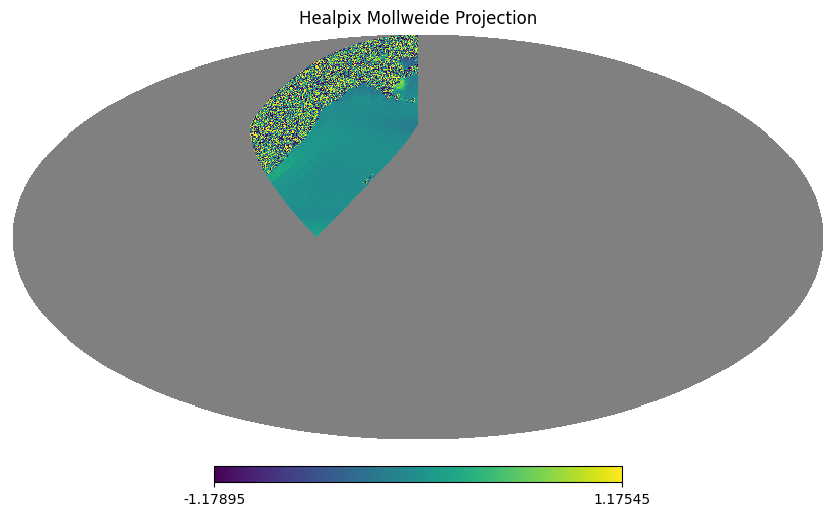

In [42]:
data = np.full((hp.nside2npix(1024), ), np.nan, dtype=np.float32)
data[df.index] = df['sample'].values
data = np.clip(data, np.nanpercentile(data, 5), np.nanpercentile(data, 95))

hp.mollview(data, title="Healpix Mollweide Projection", nest=True, cmap='viridis')

In [44]:
lon, lat = hp.pix2ang(1024, df.index.values, nest=True, lonlat=True)
sample_ds = pd.DataFrame({
    'lon': lon,
    'lat': lat,
    'fco2_hat': df['sample'].values,
    'sst_cci': df['sst_cci'].values,
    'sss_cci': df['sss_cci'].values,
})
print(sample_ds.lon.min(), sample_ds.lon.max(), sample_ds.lat.min(), sample_ds.lat.max())
sample_ds['lon'] = np.round(sample_ds['lon']*4, 0) / 4
sample_ds['lat'] = np.round(sample_ds['lat']*4, 0) / 4
sample_ds.set_index(['lon', 'lat'], inplace=True)
sample_ds = sample_ds.groupby(['lat', 'lon']).mean().to_xarray()

0.0439453125 89.9560546875 0.03730194242227469 89.95431463934247


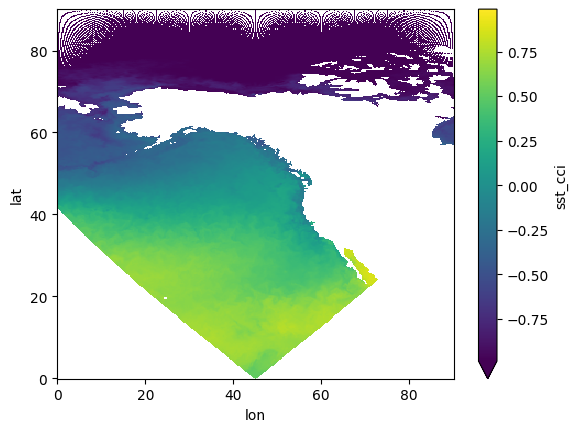

In [46]:
sample_ds.sst_cci.plot.imshow(cmap='viridis', robust=True, add_colorbar=True)